练习迁移学习，自己准备的数据集， 包括三个类别：  
狗：train：265张，val：143张  
鱼：train：243张，val：124张  
蝴蝶：train：214张， val：101张  

In [1]:
# Author: RocZhang

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

加载数据集，使用官网的数据加强方法。  

In [2]:
# 这一段引用pytorch官网
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 改变图片大小一适应网络的输入
        transforms.RandomHorizontalFlip(),  # 以给定的概率水平翻转给定的图像，图像增强的方法
        transforms.ToTensor(),  # 将图片转换成为Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 用均值和标准差对张量图像进行归一化。
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
!mkdir data
!cp /content/drive/MyDrive/data/img/RocZhang.rar /content/data
!unrar x data/RocZhang.rar

/bin/bash: uzip: command not found


In [7]:
!mv RocZhang data/

In [8]:
data_dir = 'data/RocZhang'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
class_names

['butterfly', 'dog', 'fish']

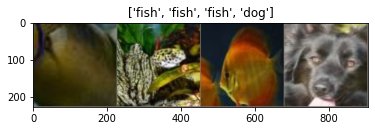

In [12]:
# 图片展示函数
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# 获取一些数据
inputs, classes = next(iter(dataloaders['train']))

# 将四张图片连起来显示
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
# 训练函数
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
# 查看模型函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7898 Acc: 0.6814
val Loss: 0.4155 Acc: 0.8505

Epoch 1/24
----------
train Loss: 0.7388 Acc: 0.7230
val Loss: 0.4971 Acc: 0.8043

Epoch 2/24
----------
train Loss: 0.6787 Acc: 0.7382
val Loss: 0.3543 Acc: 0.8533

Epoch 3/24
----------
train Loss: 0.7311 Acc: 0.7188
val Loss: 0.5964 Acc: 0.7663

Epoch 4/24
----------
train Loss: 0.6442 Acc: 0.7618
val Loss: 0.2661 Acc: 0.9049

Epoch 5/24
----------
train Loss: 0.6591 Acc: 0.7410
val Loss: 0.5029 Acc: 0.8505

Epoch 6/24
----------
train Loss: 0.6097 Acc: 0.7701
val Loss: 0.2995 Acc: 0.8913

Epoch 7/24
----------
train Loss: 0.4795 Acc: 0.8269
val Loss: 0.2821 Acc: 0.9049

Epoch 8/24
----------
train Loss: 0.3965 Acc: 0.8560
val Loss: 0.2292 Acc: 0.9185

Epoch 9/24
----------
train Loss: 0.3417 Acc: 0.8684
val Loss: 0.3030 Acc: 0.9076

Epoch 10/24
----------
train Loss: 0.3817 Acc: 0.8490
val Loss: 0.2197 Acc: 0.9212

Epoch 11/24
----------
train Loss: 0.3382 Acc: 0.8809
val Loss: 0.2490 Acc: 0.9103

Ep

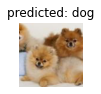

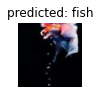

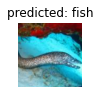

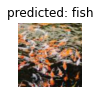

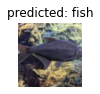

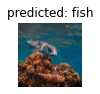

In [17]:
visualize_model(model_ft)

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8649 Acc: 0.6316
val Loss: 0.2417 Acc: 0.9076

Epoch 1/24
----------
train Loss: 0.6226 Acc: 0.7576
val Loss: 0.1846 Acc: 0.9348

Epoch 2/24
----------
train Loss: 0.5624 Acc: 0.7853
val Loss: 0.2146 Acc: 0.9212

Epoch 3/24
----------
train Loss: 0.5806 Acc: 0.7673
val Loss: 0.1479 Acc: 0.9538

Epoch 4/24
----------
train Loss: 0.6166 Acc: 0.7687
val Loss: 0.1836 Acc: 0.9348

Epoch 5/24
----------
train Loss: 0.6665 Acc: 0.7507
val Loss: 0.2128 Acc: 0.9158

Epoch 6/24
----------
train Loss: 0.5513 Acc: 0.8019
val Loss: 0.4192 Acc: 0.8397

Epoch 7/24
----------
train Loss: 0.5215 Acc: 0.8033
val Loss: 0.1247 Acc: 0.9484

Epoch 8/24
----------
train Loss: 0.4880 Acc: 0.8283
val Loss: 0.0978 Acc: 0.9647

Epoch 9/24
----------
train Loss: 0.4362 Acc: 0.8407
val Loss: 0.1167 Acc: 0.9538

Epoch 10/24
----------
train Loss: 0.4176 Acc: 0.8421
val Loss: 0.1187 Acc: 0.9592

Epoch 11/24
----------
train Loss: 0.4135 Acc: 0.8476
val Loss: 0.1237 Acc: 0.9511

Ep

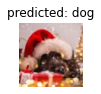

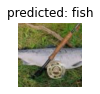

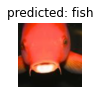

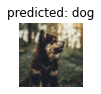

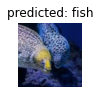

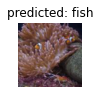

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()